In [1]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz

import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse
import rtmtools.clirad.lw.info

import rtmtools.rrtmg.lw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse



importlib.reload(aerutils)
importlib.reload(aeranalyse)
importlib.reload(viz)

importlib.reload(cliradwrangle)
importlib.reload(cliradanalyse)
importlib.reload(rtmtools.clirad.lw.info)

importlib.reload(rrtmgwrangle)
importlib.reload(rrtmganalyse)

<module 'rtmtools.rrtmg.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/rrtmg/sw/analyse.py'>

In [3]:
name_molecule = r'$H_{2}O + O_{3}$'

#### Load CRD results

In [19]:
# Get lbl line-by-line results
pathout_crd = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H2008_H2O_O3_cut25/OUTPUT_RADSUM'
pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, cooling_rate = True, signed_fluxes = True)


In [13]:
# H1996 cutoff = 10 cm-1
pathout_crd1 = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H1996_CO2_cut10/OUTPUT_RADSUM'
pnl_crd1 = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd1, cooling_rate = True, signed_fluxes = True)


#### Load CLIRAD results

In [4]:
# Read OUTPUT_CLIRAD.dat
pathout_clirad = '/nuwa_cluster/home/jackyu/radiation/clirad/LW/examples/mls75_H2O_O3_H2012/OUTPUT_CLIRAD.dat'
pnl_clirad = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad, cooling_rate = True, signed_fluxes= True)


In [11]:
pathout_clirad_96 = '/nuwa_cluster/home/jackyu/radiation/clirad/LW/examples/mls75_H2O_O3/OUTPUT_CLIRAD.dat'
pnl_clirad_96 = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad_96, cooling_rate = True, signed_fluxes= True)

In [15]:
# prepare results Hitran 2012 updated version
def path_cliradlw_h2012():
    return '../clirad/LW/examples/mls75_CO2_H2012/CLIRAD_IR_output.dat'


def get_rateT(df, ratename = 'cooling rates'):
    return pd.DataFrame({'pressure': .5 * (df['p'].values[1:] + df['p'].values[: -1]),
                    ratename: df[ratename].values[1:]})


df = cliradwrangle.output_txtfile_to_DataFrame(path_cliradlw_h2012())

rateT_clirad2012 = get_rateT(df, ratename = 'cooling rates')

#### Load LBLRTM results

In [5]:
# Get AER line-by-line results
pathout_lblrtm = '/nuwa_cluster/home/jackyu/line_by_line/aerlbl_v12.2_package/runs/LW/run_mls70pro_H2O_O3/OUTPUT_RADSUM'
pnl_lblrtm = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_lblrtm, signed_fluxes = True, cooling_rate = True)



#### Load RRTMG results

In [6]:
pathout_rrtmg = '/nuwa_cluster/home/jackyu/radiation/rrtmg/LW/examples/mls70_H2O_O3/OUTPUT_RRTM'
pnl_rrtmg = rrtmgwrangle.OUTPUT_RRTM_to_pandasPanel(readfrom = pathout_rrtmg, signed_fluxes = True, cooling_rate = True)



# Total cooling rates

In [22]:
xlim_linear = (- 0.5, 3)

In [8]:
def plot_total_cooling_rates(infos_wavenumber = None, infos_spectralband = None):
    global molecule_name, xlim_linear
    
    levels_atm = [70, 30, 0]
    
    names, colours, linestyles, dfs = [], [], [], []
    
    if infos_wavenumber:
        names_wavenumber, colours_wavenumber, linestyles_wavenumber, pnls_wavenumber = \
        map(list, zip(*infos_wavenumber))
        dfs_wavenumber = [aeranalyse.sum_OUTPUT_RADSUM_over_wbands(pnl, V1 = 0, V2 = 3000) \
                          for pnl in pnls_wavenumber]        
        
        names.extend(names_wavenumber)
        colours.extend(colours_wavenumber)
        linestyles.extend(linestyles_wavenumber)
        dfs.extend(dfs_wavenumber)
        
        
    if infos_spectralband:
        names_spectralband, colours_spectralband, linestyles_spectralband, pnls_spectralband = \
        map(list, zip(*infos_spectralband))
        dfs_spectralband = [cliradanalyse.sum_OUTPUT_CLIRAD_over_wbands(pnl, wbands = range(1, 11))\
                            for pnl in pnls_spectralband]
        
        names.extend(names_spectralband)
        colours.extend(colours_spectralband)
        linestyles.extend(linestyles_spectralband)
        dfs.extend(dfs_spectralband)
        
    
    if infos_wavenumber or infos_spectralband:
        dfs_atm = [df.loc[levels_atm, :] for df in dfs]
        viz.tabulate_difference(dfs = dfs_atm, 
                                names = names,
                                title = 'Total cooling rate. {}'.format(name_molecule))         
 
        max_cr = max([df['cooling_rate'].max() for df in dfs])

        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Total cooling rate. {}'.format(name_molecule),
                              cooling_rate = True,
                             xlim_linear = xlim_linear, 
                              xlim_log = (- .1, 20) if max_cr >= 20 else None)
    
        display.display(plt.gcf()); plt.close()
    


Total cooling rate. $H_{2}O + O_{3}$

LBLRTM
     pressure     flux_up   flux_down    net_flux  cooling_rate
70     0.0024 -324.569707    0.000000 -324.569707      0.000000
30   299.8000 -337.820265   34.362143 -303.458122      2.031523
0   1013.0000 -423.532488  277.500224 -146.032264      1.766644

CRD
       pressure     flux_up   flux_down    net_flux  cooling_rate
70     0.002417 -327.393893    0.000000 -327.393893      0.000000
30   299.800000 -338.145278   32.975966 -305.169312      2.171273
0   1013.000000 -423.662018  276.753333 -146.908685      1.821073

RRTMG
      pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -324.4923     0.0000 -324.4923       0.00000
30   299.70000 -337.0716    34.0206 -303.0510       2.00329
0   1013.00000 -423.5981   278.9265 -144.6716       1.87759

CLIRAD
       pressure     flux_up   flux_down    net_flux  cooling_rate
70     0.002417 -324.451876    0.001241 -324.450635      5.778493
30   299.800000 -336.038746   33.439628 -3

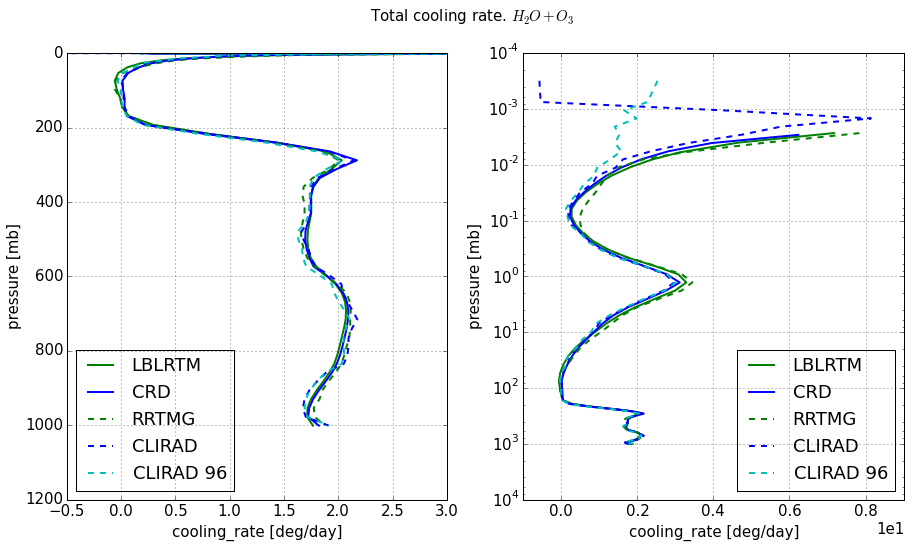

In [23]:
plot_total_cooling_rates(infos_wavenumber = [('LBLRTM', 'g', '-', pnl_lblrtm),\
                                             ('CRD', 'b', '-', pnl_crd),\
                                            ('RRTMG', 'g', '--', pnl_rrtmg)],\
                        infos_spectralband = [('CLIRAD', 'b', '--', pnl_clirad),
                                             ('CLIRAD 96', 'c', '--', pnl_clirad_96)])

In [24]:
xlim_linear = (-.5, 2)

# In RRTMG's wavenumber bands

In [25]:

def fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, *infos_lbl):
    global name_molecule, xlim_linear
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
        
    pnls = [aeranalyse.lines2bands(pnl_lbl, wbands = pnl_rrtmg.items.values)\
           for pnl_lbl in pnls_lbl]
    
    names.append('RRTMG')
    colours.append('g')
    linestyles.append('--')
    pnls.append(pnl_rrtmg)
    
    for item in pnl_rrtmg.items:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[item].loc[atm_levels, :] for pnl in pnls]
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'RRTMG Wavenumber band: {} ~ {} cm-1'.format(*item))      

        dfs = [pnl[item] for pnl in pnls]
        
        max_cr = max([df['cooling_rate'].max() for df in dfs])        
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Cooling rate {} {} ~ {} cm-1'.format(name_molecule, *item),
                              cooling_rate = True,
                             xlim_linear = xlim_linear)
    
        display.display(plt.gcf()); plt.close()
    


Flux tables and cooling rates in RRTMG spectral bands


---------------------------------------------------------------------------


RRTMG Wavenumber band: 10.0 ~ 350.0 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -36.723333   0.000000 -36.723333      0.000000
30   299.8000 -38.985436  22.041818 -16.943618      1.331637
0   1013.0000 -54.581667  54.656243   0.074575      0.030403

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -36.618217   0.000000 -36.618217      0.000000
30   299.800000 -38.842137  22.076937 -16.765200      1.442737
0   1013.000000 -54.573788  54.550693  -0.023095      0.008350

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -36.3061     0.0000  -36.3061      -0.00000
30   299.70000 -38.7258    22.3568  -16.3690       1.36489
0   1013.00000 -54.5825    54.5778   -0.0047       0.00201

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
7

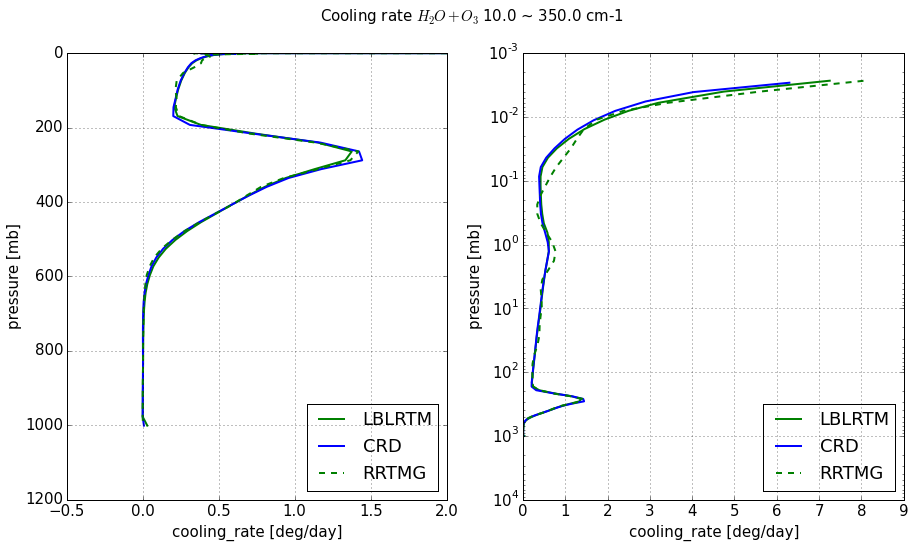

---------------------------------------------------------------------------


RRTMG Wavenumber band: 350.0 ~ 500.0 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -44.312283   0.000000 -44.312283      0.000000
30   299.8000 -45.185894   5.581771 -39.604122      0.506824
0   1013.0000 -60.917465  60.568476  -0.348988      0.074194

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -44.422999   0.000000 -44.422999      0.000000
30   299.800000 -45.270518   5.428052 -39.842466      0.522785
0   1013.000000 -60.916638  60.564791  -0.351847      0.065126

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -44.3208     0.0000  -44.3208      -0.00000
30   299.70000 -45.1535     5.2688  -39.8847       0.46769
0   1013.00000 -60.9174    60.7515   -0.1659       0.05173

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.110717   0.000000  0.110717      0.00000

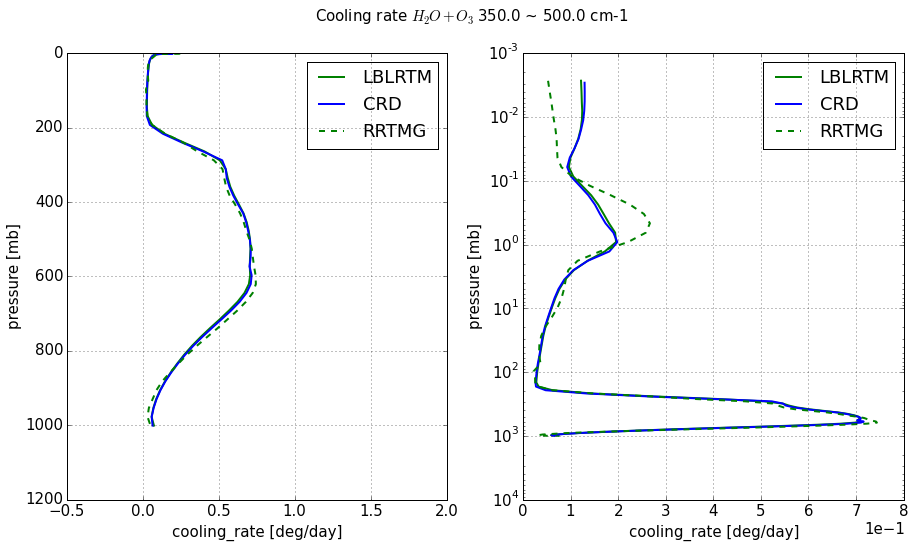

---------------------------------------------------------------------------


RRTMG Wavenumber band: 500.0 ~ 630.0 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -46.991328   0.000000 -46.991328      0.000000
30   299.8000 -47.308140   1.272092 -46.036048      0.126761
0   1013.0000 -58.646623  53.248523  -5.398100      0.367814

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -47.204841   0.000000 -47.204841      0.000000
30   299.800000 -47.486463   1.183130 -46.303334      0.124701
0   1013.000000 -58.652387  53.147737  -5.504650      0.378407

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -47.0755     0.0000  -47.0755      -0.00000
30   299.70000 -47.3985     1.1975  -46.2010       0.11909
0   1013.00000 -58.6463    54.0152   -4.6311       0.40161

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.213513   0.000000  0.213513      0.00000

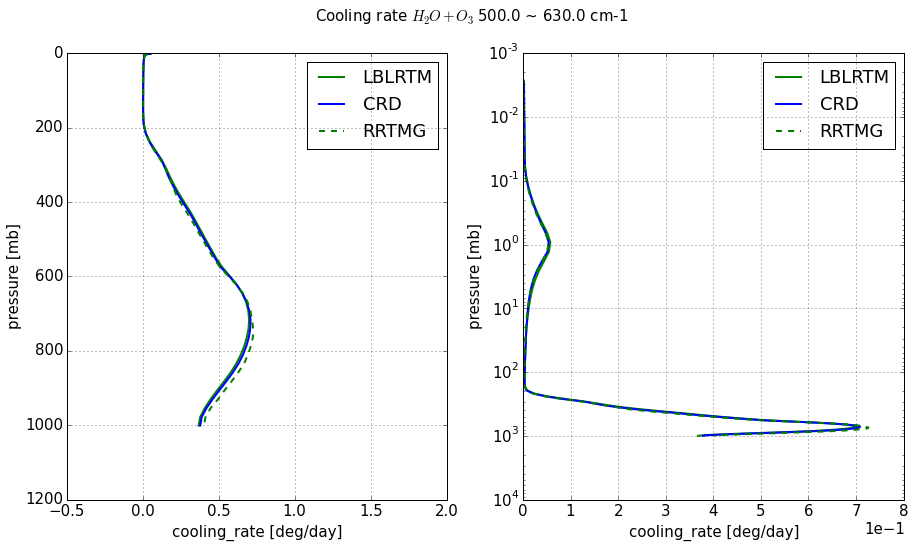

---------------------------------------------------------------------------


RRTMG Wavenumber band: 630.0 ~ 700.0 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -26.331761   0.000000 -26.331761      0.000000
30   299.8000 -27.072889   0.657345 -26.415544      0.017980
0   1013.0000 -30.895458  20.546403 -10.349054      0.287059

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -27.069898   0.000000 -27.069898      0.000000
30   299.800000 -27.127383   0.173199 -26.954184      0.019684
0   1013.000000 -30.901144  20.322693 -10.578451      0.298899

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -26.8884     0.0000  -26.8884      -0.00000
30   299.70000 -27.1641     0.4453  -26.7188       0.00969
0   1013.00000 -30.8951    20.5957  -10.2994       0.31663

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.738136   0.000000  0.738136      0.00000

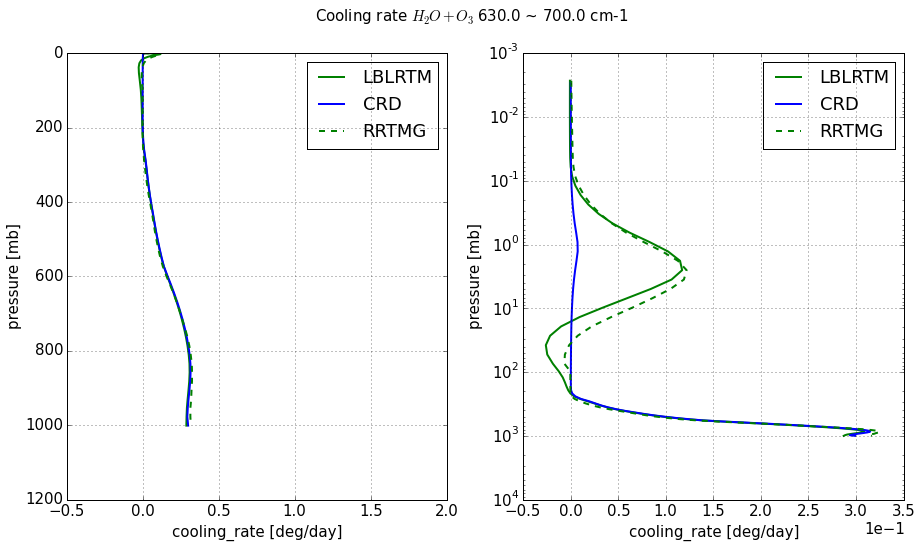

---------------------------------------------------------------------------


RRTMG Wavenumber band: 700.0 ~ 820.0 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -44.911107   0.000000 -44.911107      0.000000
30   299.8000 -45.927985   0.605569 -45.322417      0.004189
0   1013.0000 -48.886744  17.476614 -31.410130      0.357341

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -45.981097   0.000000 -45.981097      0.000000
30   299.800000 -46.010205   0.058138 -45.952067      0.005716
0   1013.000000 -48.899846  17.046923 -31.852922      0.372074

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -45.3349     0.0000  -45.3349      -0.00000
30   299.70000 -45.9865     0.5187  -45.4678       0.00012
0   1013.00000 -48.8867    17.2026  -31.6841       0.38351

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  1.069990   0.000000  1.069990      0.00000

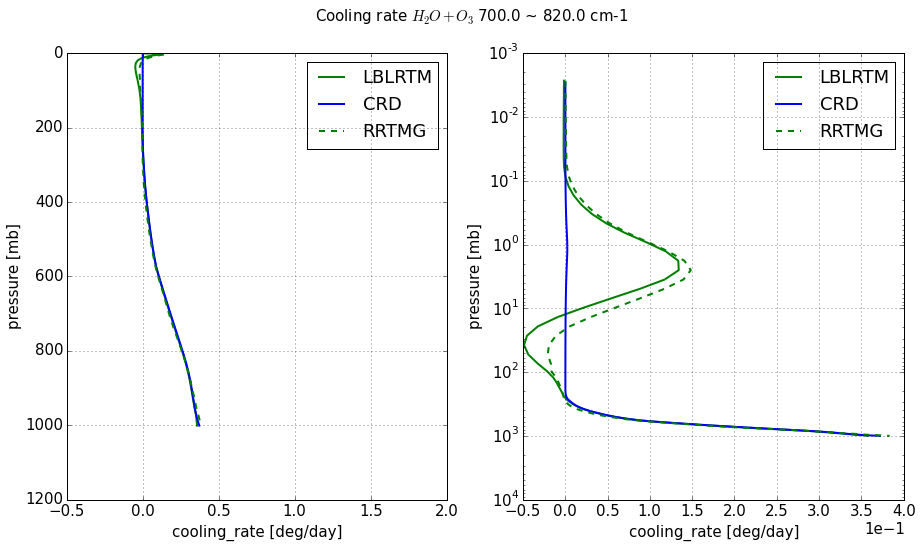

---------------------------------------------------------------------------


RRTMG Wavenumber band: 820.0 ~ 980.0 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -52.992730   0.000000 -52.992730      0.000000
30   299.8000 -53.024760   0.015904 -53.008856     -0.000096
0   1013.0000 -53.960338   5.977645 -47.982692      0.168629

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -53.054398   0.000000 -53.054398      0.000000
30   299.800000 -53.059742   0.004696 -53.055046     -0.000011
0   1013.000000 -53.981634   6.000207 -47.981427      0.178273

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -53.0264     0.0000  -53.0264      -0.00000
30   299.70000 -53.0324     0.0038  -53.0286      -0.00025
0   1013.00000 -53.9607     6.1714  -47.7893       0.18999

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.061668   0.000000  0.061668      0.00000

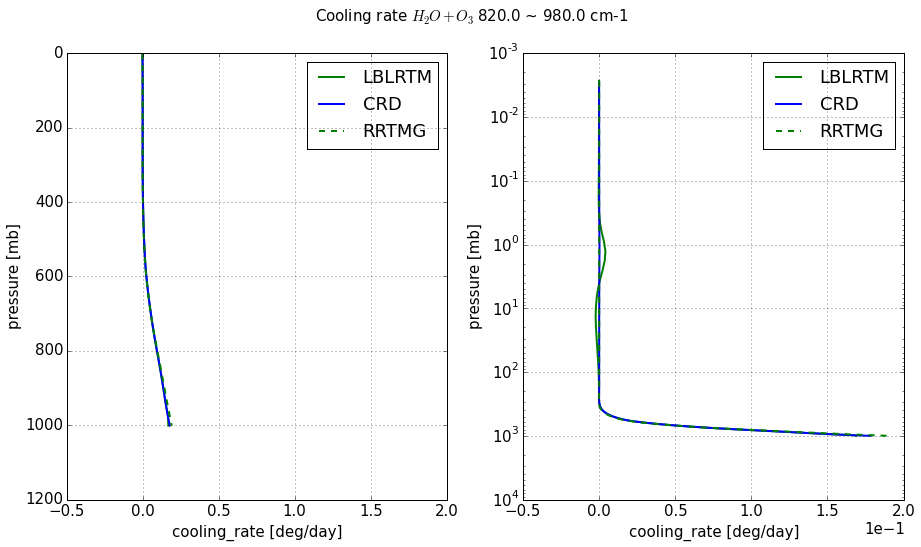

---------------------------------------------------------------------------


RRTMG Wavenumber band: 980.0 ~ 1080.0 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -18.173406   0.000000 -18.173406      0.000000
30   299.8000 -24.428842   2.035983 -22.392859     -0.059937
0   1013.0000 -26.640246   6.014523 -20.625722      0.077639

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -18.356803   0.000000 -18.356803      0.000000
30   299.800000 -24.428191   2.022901 -22.405290     -0.058143
0   1013.000000 -26.654056   6.038988 -20.615068      0.081740

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -17.9002     0.0000  -17.9002      -0.00000
30   299.70000 -24.2873     1.9846  -22.3027      -0.06366
0   1013.00000 -26.6402     5.9658  -20.6744       0.08537

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.183398   0.000000  0.183398      0.0000

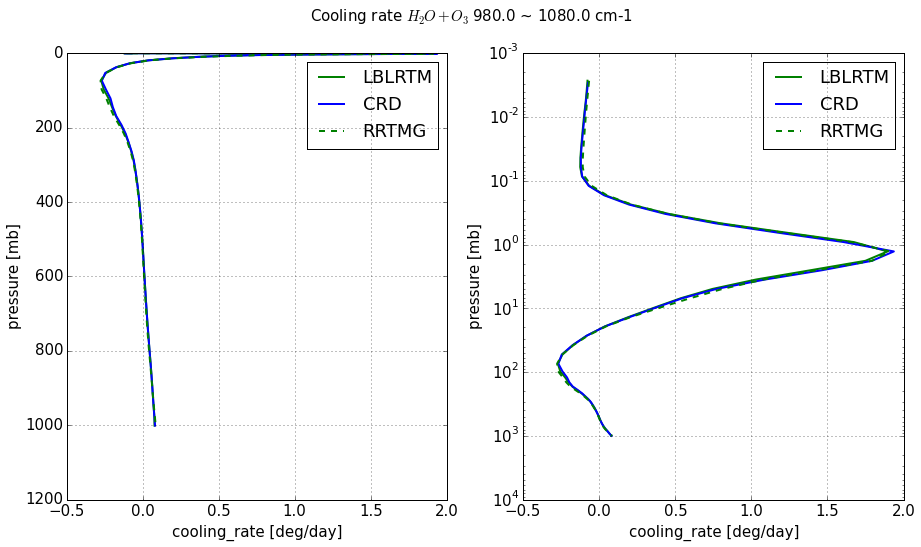

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1080.0 ~ 1180.0 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -19.978766   0.000000 -19.978766      0.000000
30   299.8000 -20.511573   0.143795 -20.367777     -0.001148
0   1013.0000 -21.522739   4.500923 -17.021816      0.111018

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -20.390944   0.000000 -20.390944      0.000000
30   299.800000 -20.549665   0.048519 -20.501145     -0.000237
0   1013.000000 -21.535940   4.410002 -17.125938      0.114840

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -20.1213     0.0000  -20.1213      -0.00000
30   299.70000 -20.4973     0.1334  -20.3639      -0.00164
0   1013.00000 -21.5225     4.6236  -16.8989       0.12175

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.412178   0.000000  0.412178      0.000

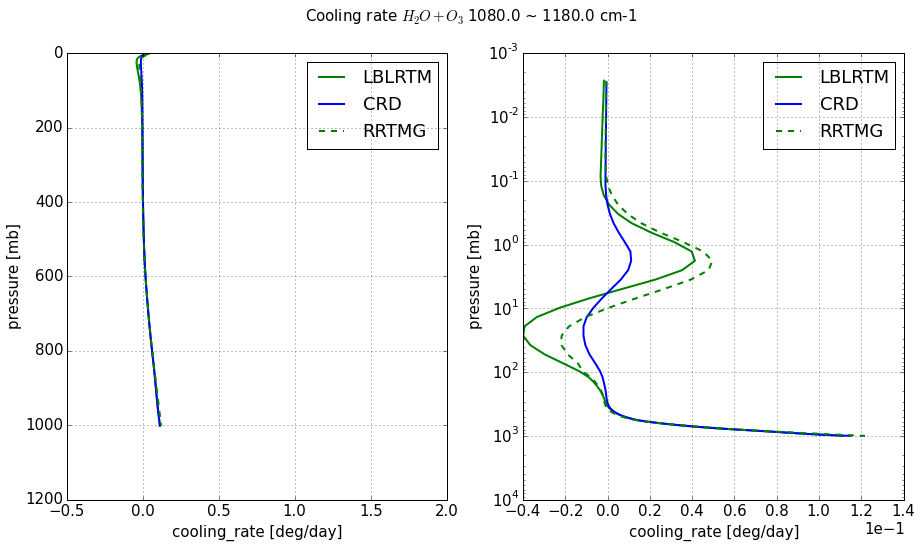

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1180.0 ~ 1390.0 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -22.366215   0.000000 -22.366215      0.000000
30   299.8000 -22.534496   0.244214 -22.290282      0.013171
0   1013.0000 -31.299603  22.004869  -9.294734      0.247364

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -22.364859   0.000000 -22.364859      0.000000
30   299.800000 -22.516322   0.240063 -22.276259      0.013872
0   1013.000000 -31.323236  22.084979  -9.238257      0.247089

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -22.0664     0.0000  -22.0664      -0.00000
30   299.70000 -22.3024     0.3088  -21.9936       0.01648
0   1013.00000 -31.2998    22.2084   -9.0914       0.25038

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017 -0.001356   0.000000 -0.001356      0.000

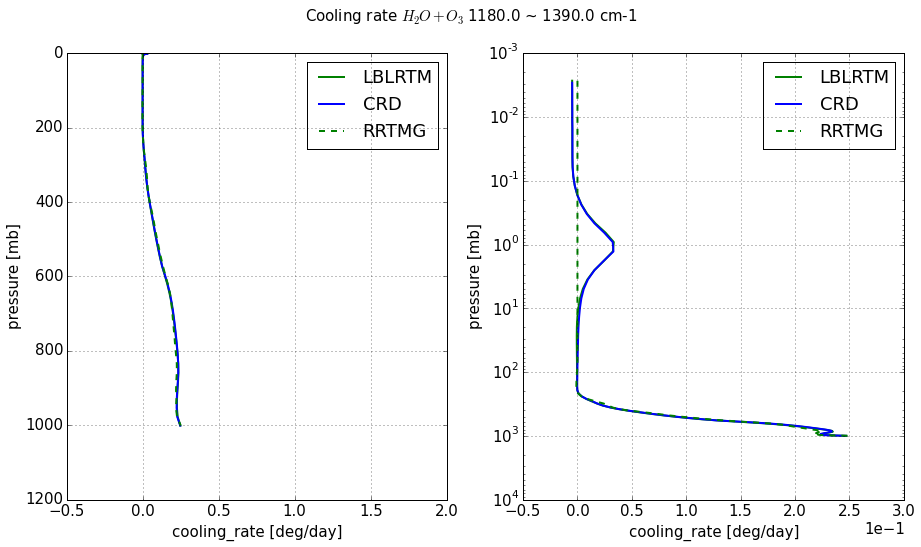

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1390.0 ~ 1480.0 cm-1

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -2.543028   0.000000 -2.543028      0.000000
30   299.8000 -2.778225   0.450180 -2.328045      0.026118
0   1013.0000 -8.898490   8.879339 -0.019151      0.004225

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -2.529233   0.000000 -2.529233      0.000000
30   299.800000 -2.762602   0.447570 -2.315032      0.027789
0   1013.000000 -8.906562   8.890356 -0.016206      0.005849

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -2.4808     0.0000   -2.4808      -0.00000
30   299.70000  -2.7200     0.4662   -2.2538       0.02661
0   1013.00000  -8.8986     8.8866   -0.0120       0.00512

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017 -0.013796   0.000000 -0.013796      0.000000
30  0.000000

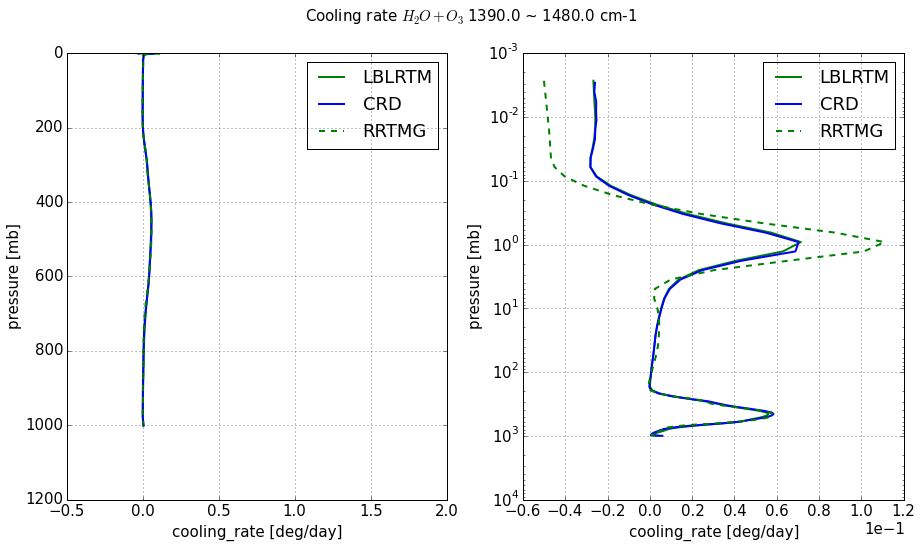

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1480.0 ~ 1800.0 cm-1

LBLRTM
     pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.0024  -3.360062   0.000000 -3.360062      0.000000
30   299.8000  -4.019533   1.250381 -2.769152      0.065554
0   1013.0000 -17.882889  17.851415 -0.031473      0.004635

CRD
       pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.002417  -3.353829   0.000000 -3.353829      0.000000
30   299.800000  -3.996974   1.237523 -2.759451      0.071399
0   1013.000000 -17.902258  17.865359 -0.036899      0.013083

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -3.2226     0.0000   -3.2226      -0.00000
30   299.70000  -3.8991     1.2651   -2.6340       0.06488
0   1013.00000 -17.8828    17.8685   -0.0143       0.00607

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017 -0.006233   0.000000 -0.006233      0.000000
30  

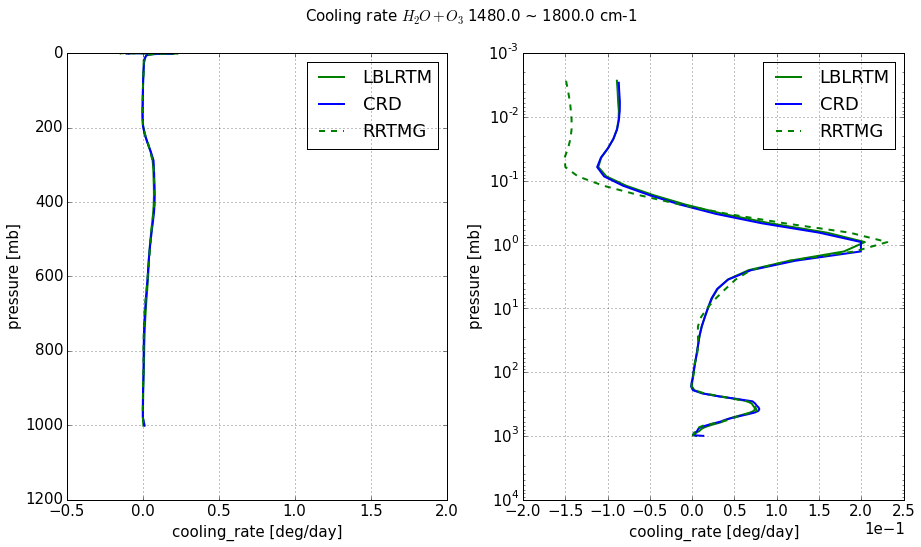

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1800.0 ~ 2080.0 cm-1

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -2.768159   0.000000 -2.768159      0.000000
30   299.8000 -2.832712   0.057601 -2.775111      0.001004
0   1013.0000 -5.957771   5.180461 -0.777310      0.018989

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -2.816395   0.000000 -2.816395      0.000000
30   299.800000 -2.863743   0.054956 -2.808787      0.001090
0   1013.000000 -5.965987   5.251580 -0.714406      0.039084

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -2.7629     0.0000   -2.7629      -0.00000
30   299.70000  -2.8171     0.0630   -2.7541       0.00084
0   1013.00000  -5.9578     5.2503   -0.7075       0.04283

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.048236   0.000000  0.048236      0.000000
30  0.000000

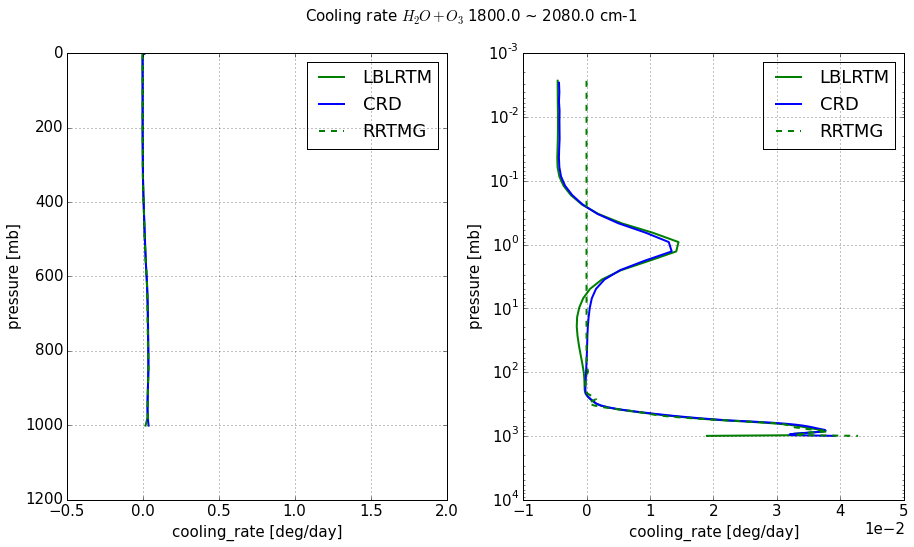

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2080.0 ~ 2250.0 cm-1

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -1.370213   0.000000 -1.370213      0.000000
30   299.8000 -1.461618   0.005416 -1.456202     -0.000493
0   1013.0000 -1.639014   0.462896 -1.176118      0.013175

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -1.477430   0.000000 -1.477430      0.000000
30   299.800000 -1.478102   0.000236 -1.477865     -0.000072
0   1013.000000 -1.641655   0.446475 -1.195180      0.013461

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242   -1.339     0.0000   -1.3390      -0.00000
30   299.70000   -1.418     0.0077   -1.4103      -0.00022
0   1013.00000   -1.639     0.5433   -1.0957       0.01450

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.107217   0.000000  0.107217      0.000000
30  0.000000

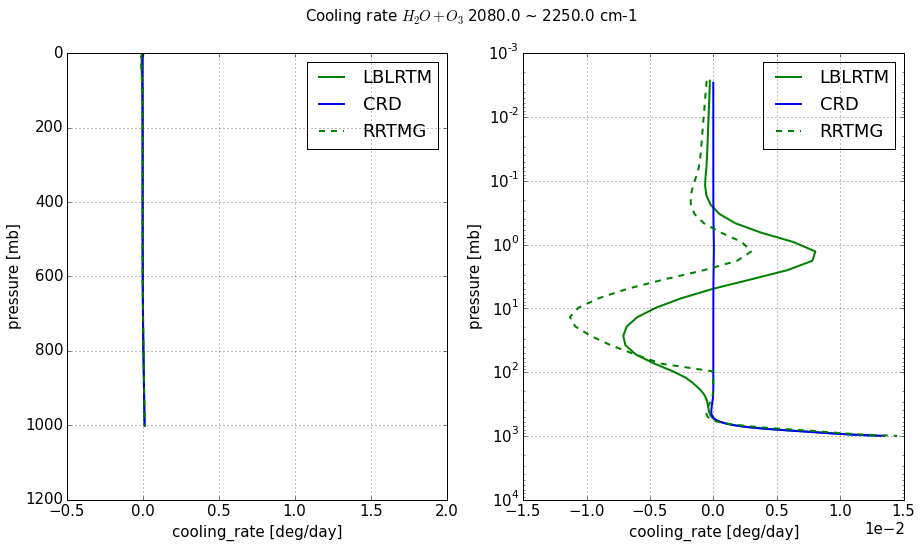

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2250.0 ~ 2380.0 cm-1

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.716912   0.000000 -0.716912      0.000000
30   299.8000 -0.717057   0.000010 -0.717047     -0.000005
0   1013.0000 -0.731556   0.046017 -0.685539      0.001722

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.718921   0.000000 -0.718921      0.000000
30   299.800000 -0.718951   0.000003 -0.718948     -0.000005
0   1013.000000 -0.732844   0.045352 -0.687492      0.001860

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.7315          0   -0.7315            -0
30   299.70000  -0.7315          0   -0.7315            -0
0   1013.00000  -0.7316          0   -0.7316            -0

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.002010   0.000000  0.002010  0.000000e+00
30  0.000000

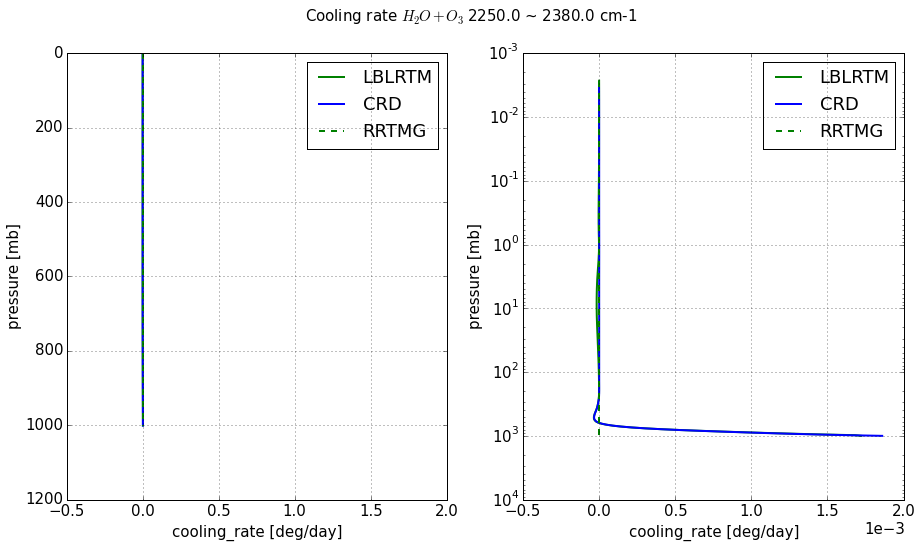

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2380.0 ~ 2600.0 cm-1

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.662149   0.000000 -0.662149      0.000000
30   299.8000 -0.662204   0.000002 -0.662202     -0.000002
0   1013.0000 -0.665840   0.008846 -0.656994      0.000234

CRD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -0.663910  0.000000e+00 -0.663910      0.000000
30   299.800000 -0.663925  7.815591e-07 -0.663924     -0.000002
0   1013.000000 -0.667119  8.808146e-03 -0.658311      0.000385

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.5487     0.0000   -0.5487      -0.00000
30   299.70000  -0.5702     0.0007   -0.5695      -0.00110
0   1013.00000  -0.6658     0.1142   -0.5516       0.00312

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.001761   0.000000  0.001761  0.000000e+00


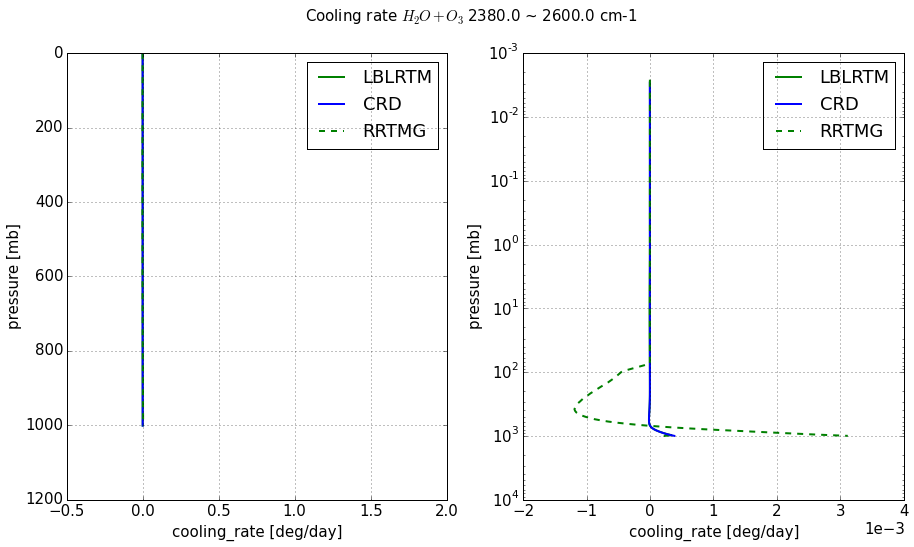

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2600.0 ~ 3250.0 cm-1

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.365655   0.000000 -0.365655      0.000000
30   299.8000 -0.366297   0.000032 -0.366265     -0.000035
0   1013.0000 -0.403547   0.075453 -0.328094      0.002112

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.367763   0.000000 -0.367763      0.000000
30   299.800000 -0.367997   0.000020 -0.367977     -0.000034
0   1013.000000 -0.404431   0.076088 -0.328343      0.002536

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.3668     0.0000   -0.3668      -0.00000
30   299.70000  -0.3679     0.0002   -0.3677      -0.00013
0   1013.00000  -0.4713     0.1516   -0.3197       0.00297

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.002108   0.000000  0.002108  0.000000e+00
30  0.000000

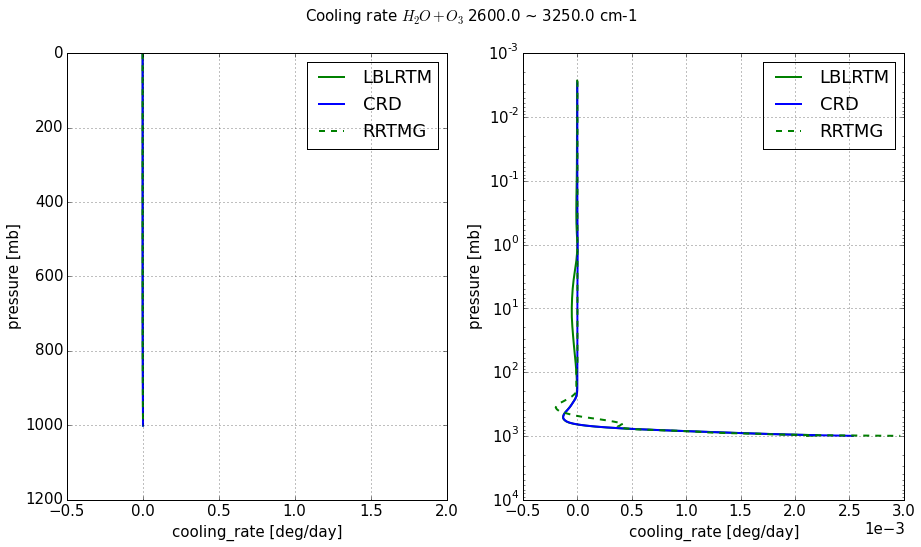

In [26]:
print('Flux tables and cooling rates in RRTMG spectral bands')
print()
print()

fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg,\
                                ('LBLRTM', 'g', '-', pnl_lblrtm),
                               ('CRD', 'b', '-', pnl_crd))   

# In CLIRAD's wavenumber bands

In [27]:


def fluxtableNhrplot_by_clirad_bands(pnl_clirad, *infos_lbl):    
    global name_molecule, xlim_linear
    
    clirad_wbands = rtmtools.clirad.lw.info.wavenumber_bands()
    wbands = list(range(1, 10 + 1))
    wranges = {wband: clirad_wbands[wband] for wband in wbands}
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
        

    
    pnls = [rtmtools.clirad.sw.analyse.lines2bands(pnl_lbl, wbands = wranges)\
            for pnl_lbl in pnls_lbl]
    
    names.append('CLIRAD')
    colours.append('b')
    linestyles.append('--')
    pnls.append(pnl_clirad)
    
    for wband in wbands:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[wband].loc[atm_levels, :] for pnl in pnls]
        
        wlabel = ' '.join(['{} ~ {}'.format(*interval) for interval in wranges[wband]]) + ' cm-1'
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'Wavenumber band: {}, {}'.format(wband, wlabel))
        
        dfs = [pnl[wband] for pnl in pnls]
        
        max_cr = max([df['cooling_rate'].max() for df in dfs])       

        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Cooling rate {} {}'.format(name_molecule, wlabel),
                              cooling_rate = True,
                             xlim_linear = xlim_linear)
    
        display.display(plt.gcf()); plt.close()    


Flux tables and cooling rates in CLIRAD spectral bands


---------------------------------------------------------------------------


Wavenumber band: 1, 0 ~ 340 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -34.414197   0.000000 -34.414197      0.000000
30   299.8000 -36.581571  21.338405 -15.243165      1.268607
0   1013.0000 -51.100657  51.173330   0.072673      0.029632

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -34.310935   0.000000 -34.310935      0.000000
30   299.800000 -36.441826  21.391389 -15.050438      1.376942
0   1013.000000 -51.093040  51.071508  -0.021532      0.007733

CLIRAD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -34.03330   0.001232 -34.032068      6.148719
30   299.800000 -36.40643  21.663380 -14.743050      1.350754
0   1013.000000 -51.09213  51.070570  -0.021560      0.007725

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_

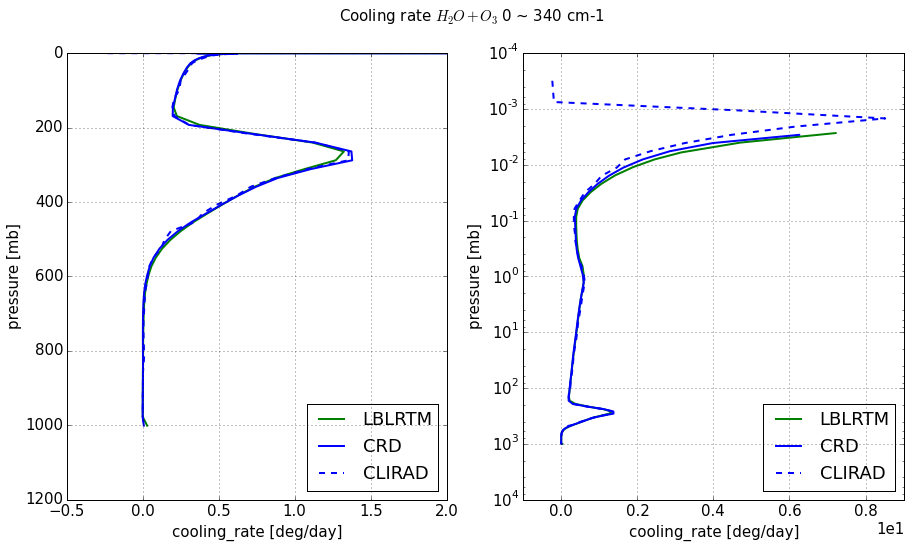

---------------------------------------------------------------------------


Wavenumber band: 2, 340 ~ 540 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -60.328378   0.000000 -60.328378      0.000000
30   299.8000 -61.423874   6.869349 -54.554524      0.627764
0   1013.0000 -82.315849  81.374679  -0.941170      0.139025

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -60.541409   0.000000 -60.541409      0.000000
30   299.800000 -61.600467   6.651864 -54.948602      0.644241
0   1013.000000 -82.315835  81.330012  -0.985823      0.130917

CLIRAD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -59.82235   0.000003 -59.822347     -0.097136
30   299.800000 -60.99290   6.915163 -54.077737      0.649110
0   1013.000000 -82.31579  81.543440  -0.772350      0.156217

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.213031   0.000000  0.213031      0

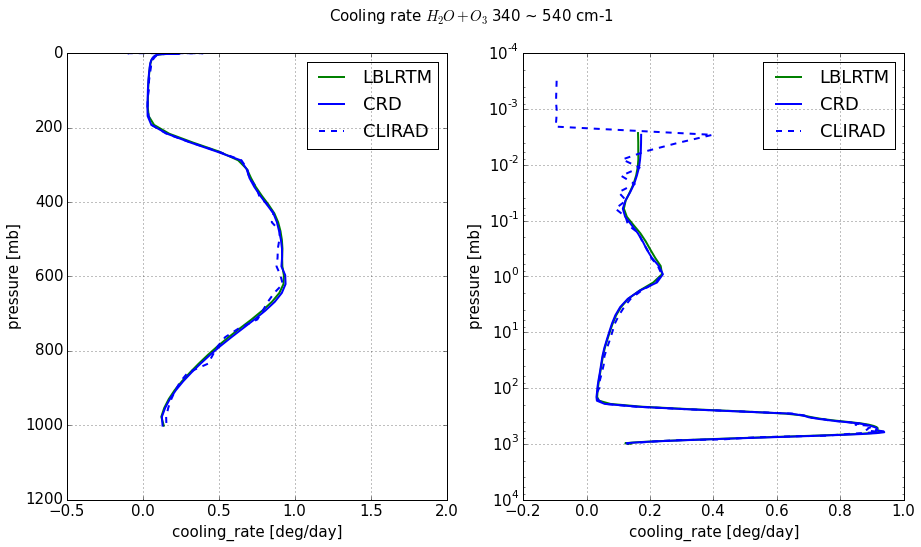

---------------------------------------------------------------------------


Wavenumber band: 3, 540 ~ 800 cm-1

LBLRTM
     pressure     flux_up  flux_down   net_flux  cooling_rate
70     0.0024  -97.107972   0.000000 -97.107972      0.000000
30   299.8000  -99.044507   1.944261 -97.100246      0.090971
0   1013.0000 -112.816764  72.265104 -40.551659      0.906351

CRD
       pressure     flux_up  flux_down   net_flux  cooling_rate
70     0.002417  -99.015291   0.000000 -99.015291      0.000000
30   299.800000  -99.263422   0.874413 -98.389009      0.094366
0   1013.000000 -112.837813  71.524950 -41.312864      0.940123

CLIRAD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417  -97.71744   0.000003 -97.717437     -0.000004
30   299.800000  -97.92890   0.674001 -97.254899      0.089588
0   1013.000000 -112.81600  73.117410 -39.698590      0.909037

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  1.907319   0.000000  1.9

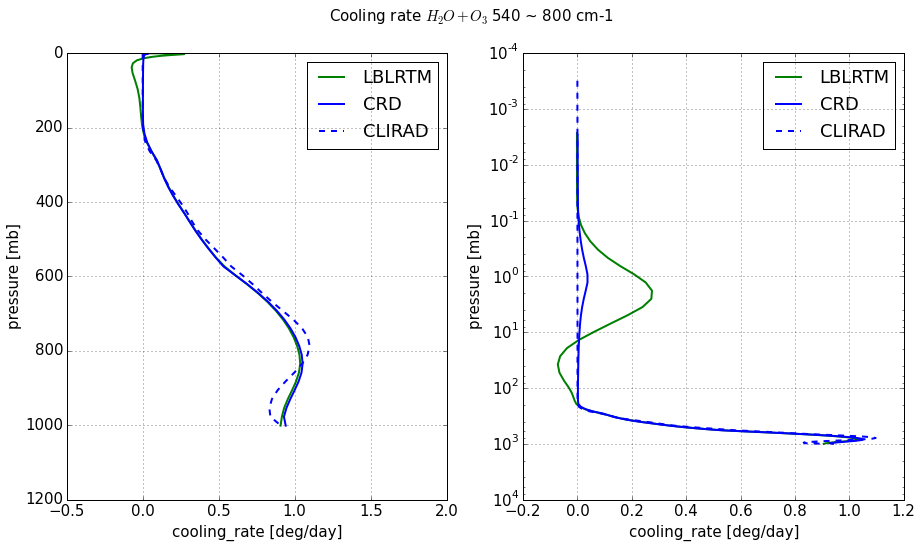

---------------------------------------------------------------------------


Wavenumber band: 4, 800 ~ 980 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -60.414595   0.000000 -60.414595      0.000000
30   299.8000 -60.457758   0.022513 -60.435245     -0.000045
0   1013.0000 -61.657526   7.662368 -53.995158      0.210523

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -60.486170   0.000000 -60.486170      0.000000
30   299.800000 -60.493092   0.006507 -60.486585      0.000067
0   1013.000000 -61.681243   7.708875 -53.972367      0.222374

CLIRAD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -60.32822  6.214958e-10 -60.328220     -0.000000
30   299.800000 -60.33170  2.764044e-03 -60.328936     -0.000079
0   1013.000000 -61.64931  8.491215e+00 -53.158095      0.242118

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.071576   0.000000  0.0

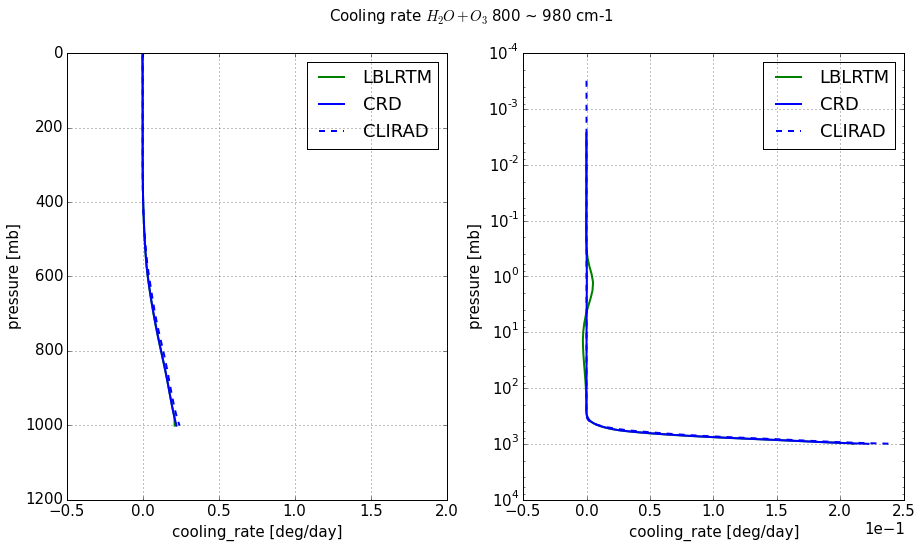

---------------------------------------------------------------------------


Wavenumber band: 5, 980 ~ 1100 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -22.623940   0.000000 -22.623940      0.000000
30   299.8000 -29.031736   2.077001 -26.954735     -0.060277
0   1013.0000 -31.337711   6.514053 -24.823658      0.090661

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -22.813684   0.000000 -22.813684      0.000000
30   299.800000 -29.036726   2.064475 -26.972251     -0.058492
0   1013.000000 -31.354231   6.525026 -24.829205      0.094922

CLIRAD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -22.22709  4.351434e-07 -22.22709     -0.107483
30   299.800000 -28.93797  2.174080e+00 -26.76389     -0.056226
0   1013.000000 -31.34389  7.188680e+00 -24.15521      0.108485

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.189744   0.000000  0.1897

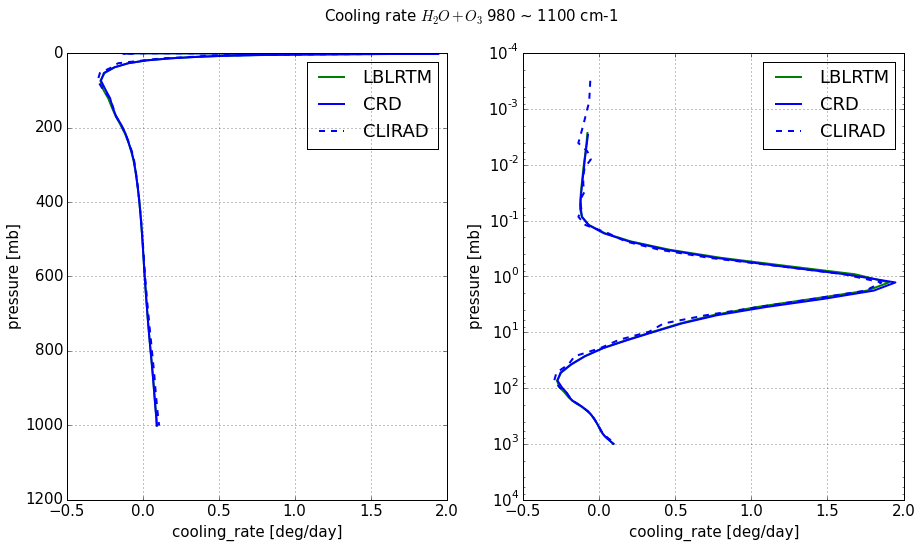

---------------------------------------------------------------------------


Wavenumber band: 6, 1100 ~ 1215 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -21.342303   0.000000 -21.342303      0.000000
30   299.8000 -21.743428   0.112803 -21.630625     -0.000664
0   1013.0000 -23.254791   6.402752 -16.852039      0.155971

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -21.773071   0.000000 -21.773071      0.000000
30   299.800000 -21.785504   0.012772 -21.772732      0.000306
0   1013.000000 -23.269652   6.305412 -16.964240      0.160466

CLIRAD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -21.79535  2.657388e-13 -21.795350 -3.024772e-09
30   299.800000 -21.80484  8.713370e-03 -21.796127  9.956238e-05
0   1013.000000 -23.27341  6.326471e+00 -16.946939  1.579750e-01

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.430768   0.000000  0

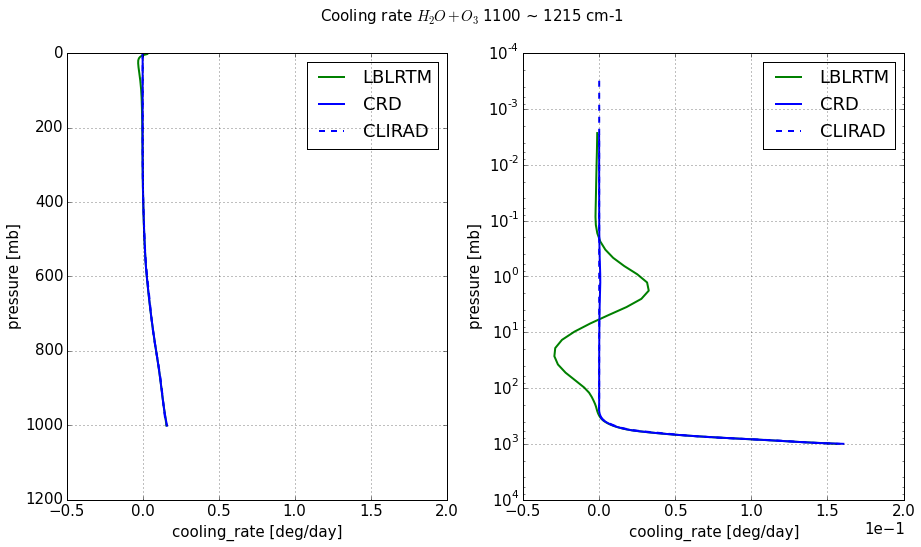

---------------------------------------------------------------------------


Wavenumber band: 7, 1215 ~ 1380 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -16.085725   0.000000 -16.085725      0.000000
30   299.8000 -16.218182   0.208057 -16.010124      0.011500
0   1013.0000 -23.736876  18.476415  -5.260461      0.187592

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -16.067263   0.000000 -16.067263      0.000000
30   299.800000 -16.197831   0.207324 -15.990508      0.012007
0   1013.000000 -23.755165  18.572777  -5.182388      0.187100

CLIRAD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -16.32561  4.906120e-10 -16.325610 -6.565916e-07
30   299.800000 -16.46534  2.195141e-01 -16.245826  1.407870e-02
0   1013.000000 -23.74060  1.784015e+01  -5.900450  2.084762e-01

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017 -0.018462   0.000000 -0

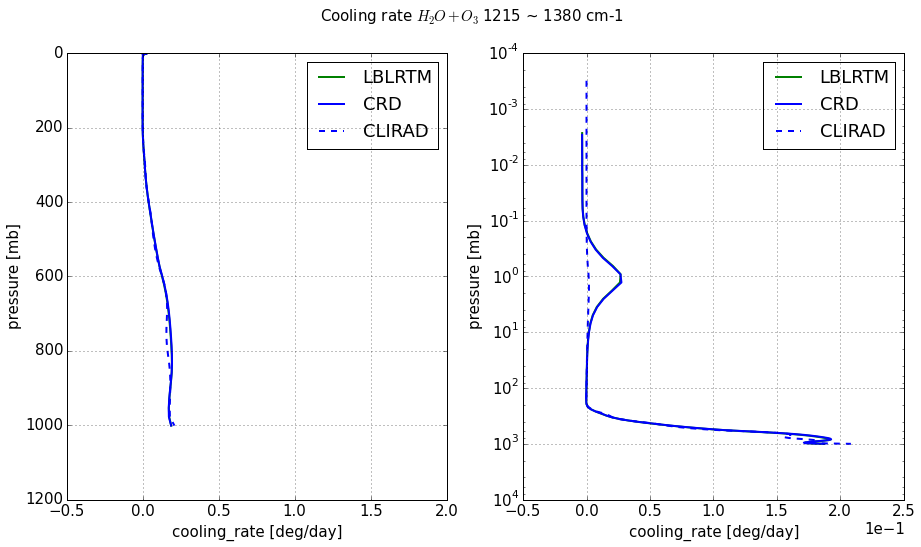

---------------------------------------------------------------------------


Wavenumber band: 8, 1380 ~ 1900 cm-1

LBLRTM
     pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.0024  -7.301218   0.000000 -7.301218      0.000000
30   299.8000  -8.246651   1.769966 -6.476685      0.094329
0   1013.0000 -30.697533  30.596922 -0.100611      0.019161

CRD
       pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.002417  -7.265696   0.000000 -7.265696      0.000000
30   299.800000  -8.191717   1.754197 -6.437520      0.102059
0   1013.000000 -30.729595  30.640991 -0.088604      0.027174

CLIRAD
       pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.002417  -7.341434   0.000002 -7.341432     -0.165602
30   299.800000  -8.295568   1.769966 -6.525602      0.097178
0   1013.000000 -30.880560  30.708790 -0.171770      0.059902

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017 -0.035523   0.000000 -0.035523      0.00000

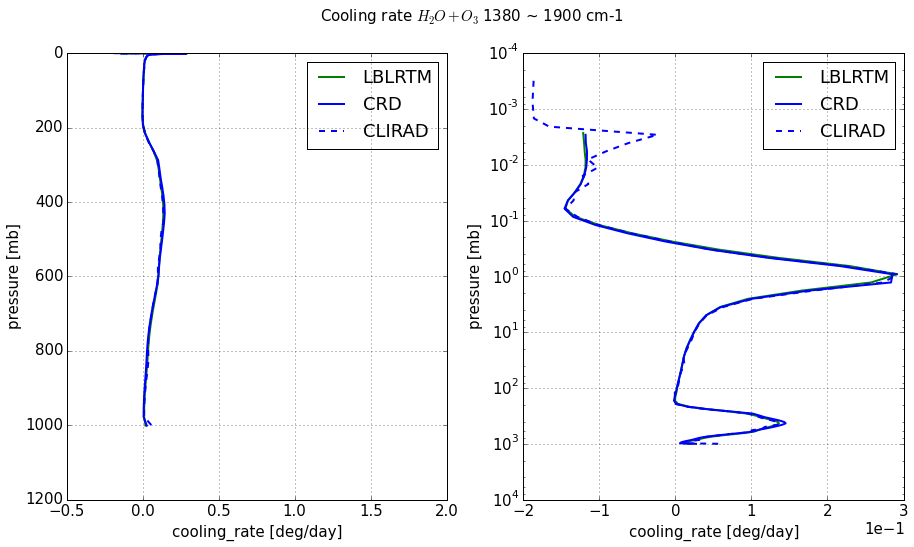

---------------------------------------------------------------------------


Wavenumber band: 9, 1900 ~ 3000 cm-1

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -4.951381   0.000000 -4.951381      0.000000
30   299.8000 -5.072559   0.019787 -5.052772     -0.000662
0   1013.0000 -6.614782   3.034602 -3.580180      0.027727

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -5.120375   0.000000 -5.120375      0.000000
30   299.800000 -5.134693   0.013024 -5.121669     -0.000221
0   1013.000000 -6.625445   3.073782 -3.551663      0.050266

CLIRAD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -4.861082   0.000000 -4.861082     -0.000000
30   299.800000 -4.875098   0.012047 -4.863051     -0.000178
0   1013.000000 -6.674498   3.427002 -3.247496      0.060868

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.168995   0.000000  0.168995      0.000000
30  0.0000

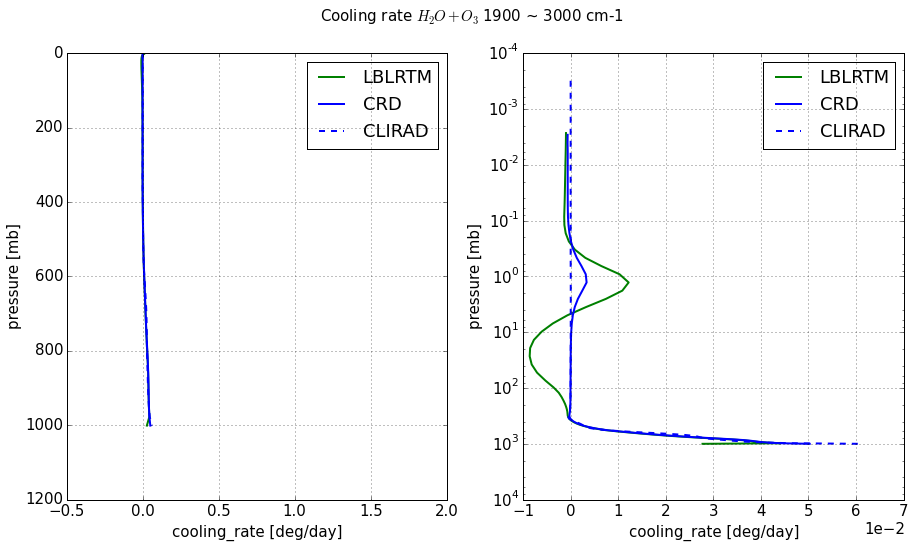

---------------------------------------------------------------------------


Wavenumber band: 10, 540 ~ 620 cm-1

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -29.448611   0.000000 -29.448611      0.000000
30   299.8000 -29.615738   0.639752 -28.975985      0.064941
0   1013.0000 -36.231410  32.413464  -3.817945      0.256049

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -29.563330   0.000000 -29.563330      0.000000
30   299.800000 -29.715745   0.607149 -29.108595      0.064925
0   1013.000000 -36.235420  32.287543  -3.947877      0.266056

CLIRAD
       pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.002417       -0          0         0            -0
30   299.800000       -0          0         0            -0
0   1013.000000       -0          0         0            -0

LBLRTM - CRD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70 -0.000017  0.114719   0.000000  0.114719      0.000000

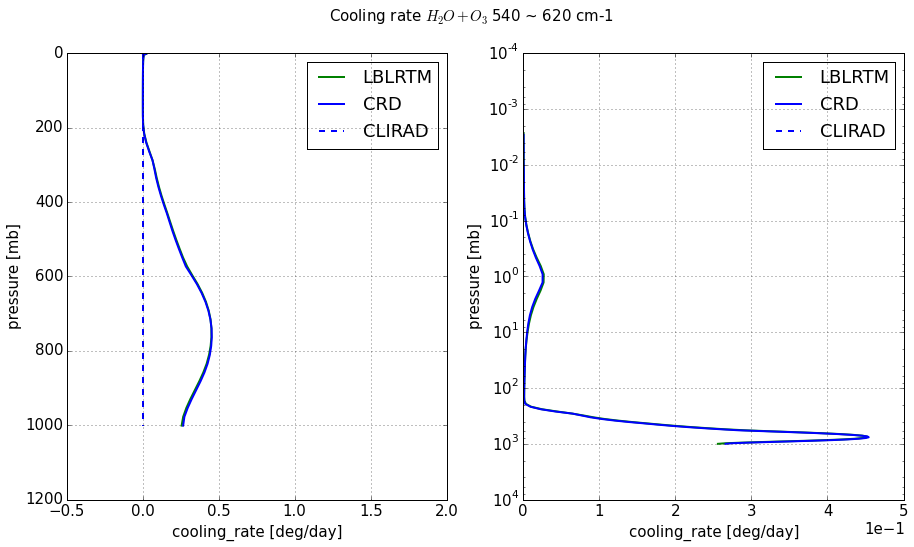

In [28]:
print('Flux tables and cooling rates in CLIRAD spectral bands')
print()
print()

fluxtableNhrplot_by_clirad_bands(pnl_clirad,\
                                ('LBLRTM', 'g', '-', pnl_lblrtm),\
                                ('CRD', 'b', '-', pnl_crd))

In [18]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')